<a href="https://colab.research.google.com/github/mmcastillo/al112248/blob/main/modelo1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
pip install natsort

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive/');
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from scipy import ndimage
import random
import natsort
import glob

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [24]:
train_img_dir = '/content/drive/MyDrive/DOCTORADO/python/datos_para_entrenar_modelos/modelo_1.X/train/50p_rand_50n/imgs/';
train_mask_dir = '/content/drive/MyDrive/DOCTORADO/python/datos_para_entrenar_modelos/modelo_1.X/train/50p_rand_50n/masks/';

train_img_list_temp = os.listdir(train_img_dir)
#train_img_list = natsort.natsorted(train_img_list)
train_mask_list_temp = os.listdir(train_mask_dir)
#train_mask_list = natsort.natsorted(train_mask_list)

#Se aleatoriza la lista del conjunto de entrenamiento
train_img_list=[]
train_mask_list=[]
inx = random.sample(range(len(train_img_list_temp)), len(train_img_list_temp))  
for i in range(len(inx)):
  train_img_list.append(train_img_list_temp[inx[i]])
  train_mask_list.append(train_mask_list_temp[inx[i]])

val_img_dir = '/content/drive/MyDrive/DOCTORADO/python/datos_para_entrenar_modelos/modelo_1.X/val/imgs/';
val_mask_dir = '/content/drive/MyDrive/DOCTORADO/python/datos_para_entrenar_modelos/modelo_1.X/val/masks/';
val_img_list = os.listdir(val_img_dir)
val_img_list = natsort.natsorted(val_img_list)
val_mask_list = os.listdir(val_mask_dir)
val_mask_list = natsort.natsorted(val_mask_list)

In [25]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [26]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            X = X.astype(np.float32)  
            Y = Y.astype(np.float32)

            #I = img_list[batch_start:limit]
            #M = mask_list[batch_start:limit]


            yield (X,Y)#,I,M) #a tuple with two numpy arrays with batch_size samples
           
            batch_start += batch_size   
            batch_end += batch_size

In [27]:
batch_size=4

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list,batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list,batch_size)


In [28]:
img,mask = train_img_datagen.__next__()
print(img.shape)
print(mask.shape)
print(np.unique(mask))

#Encuentra los patches 3D donde las máscaras contienen valores 1 y 0 (donde hay aneurisams)
#if np.unique(mask).shape[0]  == 2:
  #for i in range(mask.shape[0]):
    #if np.unique(mask[i,:,:,:]).shape[0] == 2: 
      #n_patch_aneurisma = i
      #print(f'En el patch número {n_patch_aneurisma+1} se encuentra el aneurisma')
      #n_imagenes_aneurismas=[]
      #for j in range(mask.shape[1]):
        #if np.unique(mask[n_patch_aneurisma,j,:,:]).shape[0] == 2:
          #print(f'En las imagenes {j+1}')

(4, 64, 64, 64, 1)
(4, 64, 64, 64, 1)
[0. 1.]


In [29]:
def conv_block(input, num_filters):
    x = Conv3D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv3D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    s3, p3 = encoder_block(p2, 64)
    s4, p4 = encoder_block(p3, 128)

    b1 = conv_block(p4, 256) #Bridge

    d1 = decoder_block(b1, s4, 128)
    d2 = decoder_block(d1, s3, 64)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(d3, s1, 16)

    activation = 'sigmoid'

    outputs = Conv3D(1, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(f'activation function: {activation}')

    model = Model(inputs, outputs, name="U-Net")
    return model

In [30]:
model = build_unet((64, 64, 64, 1))
print(f'model input shape: {model.input_shape}')

activation function: sigmoid
model input shape: (None, 64, 64, 64, 1)


In [31]:
!pip install segmentation-models-3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from segmentation_models_3D.losses import BinaryCELoss
import segmentation_models_3D as sm
from keras import backend as K

'''
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
'''
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

iou = tf.keras.metrics.MeanIoU(num_classes=2)

metrics = [iou, sm.metrics.FScore(), sm.metrics.Precision(), sm.metrics.Recall()]
#jaccard_loss = sm.losses.JaccardLoss()


In [33]:
LR = 0.001
optim = keras.optimizers.Adam(LR)

loss = total_loss

model.compile(optimizer=optim, loss=loss ,metrics = metrics)
print(model.summary())
print(f'LR = {LR}')
print(loss)

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_19 (Conv3D)             (None, 64, 64, 64,   448         ['input_2[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization_18 (BatchN  (None, 64, 64, 64,   64         ['conv3d_19[0][0]']              
 ormalization)                  16)                                                           

In [34]:
#Si uso el custom datagen
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=200,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('modelo_1.2.hdf5')

Epoch 1/200
225/225 [==============================] - 21s 78ms/step - loss: 1.0188 - mean_io_u_2: 0.4993 - f1-score: 0.0041 - precision: 0.0020 - recall: 0.4015 - val_loss: 1.0049 - val_mean_io_u_2: 0.5000 - val_f1-score: 1.8032e-05 - val_precision: 9.0248e-06 - val_recall: 0.9239
Epoch 2/200
225/225 [==============================] - 16s 73ms/step - loss: 0.9958 - mean_io_u_2: 0.4993 - f1-score: 0.0082 - precision: 0.0042 - recall: 0.4132 - val_loss: 1.0002 - val_mean_io_u_2: 0.5000 - val_f1-score: 1.8037e-05 - val_precision: 9.0425e-06 - val_recall: 0.9129
Epoch 3/200
225/225 [==============================] - 16s 73ms/step - loss: 0.9811 - mean_io_u_2: 0.4993 - f1-score: 0.0224 - precision: 0.0119 - recall: 0.4392 - val_loss: 1.0000 - val_mean_io_u_2: 0.5000 - val_f1-score: 1.5269e-05 - val_precision: 7.7761e-06 - val_recall: 0.9073
Epoch 4/200
225/225 [==============================] - 16s 72ms/step - loss: 0.9082 - mean_io_u_2: 0.5003 - f1-score: 0.0964 - precision: 0.0710 - reca

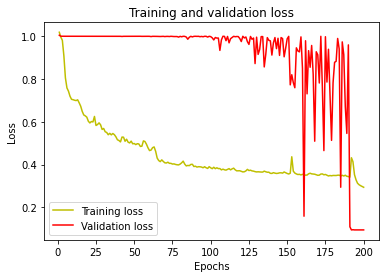

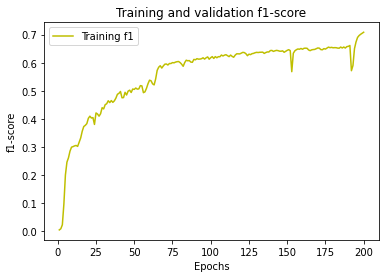

In [35]:
###
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

f1 = history.history['f1-score']

plt.plot(epochs, f1, 'y', label='Training f1')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()